# **Lab 4: Deep Learning with CNNs**
---

### **Description**
In today's lab you'll work through implementing image classification using Convolutional Neural Networks (CNNs). CNNs are mainly used for image/object recognition and classification.

You will build a CNN model using the steps of implementing a neural net from scratch with PyTorch and fast.ai.

<br>

### **Lab Structure**

**Part 1**: [Classifying Alien vs. Predator](#p1)

> **Part 1.1**: [Classifying Images with Deep Neural Networks](#p1.1)

> **Part 1.2**: [Classifying Images with Convolutional Neural Networks](#p1.2)

**Part 2**: [Chihuahua or Muffin?](#p2)

**Part 3**: [Data Augmentation](#p3)

**Part 4**: [[ADDITIONAL PRACTICE] Classification of Dogs and Cats](#p4)


<br>


### **Goals**
By the end of this lab, you will be able to:
* Build and train a CNN using PyTorch and fast.ai

<br>

### **Cheat Sheets**
* [CNNS with pytorch](https://docs.google.com/document/d/15UV1gVy5J6fzAD5vYyikiprew4erlR9Fop66h89ql0w/edit?usp=sharing)

* [Deep Learning with pytorch](https://docs.google.com/document/d/1Wm01maZUrSuwdOhuI05uZBtqt5nL5shOGnJ7kTHWl_I/edit?usp=drive_link)

<br>

**Before starting, run the code below to import all necessary functions and libraries.**


In [2]:
!pip install --quiet gdown==4.5.4 --no-cache-dir
!pip install torchsummary
from torchsummary import summary

import os
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from fastai.vision.all import *

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

from fastai.optimizer import Adam

!gdown 15L-eqjAUFhEBPxTHlUCkgATnZptUhfjj
#!unzip -qq -n alien_or_predator.zip
!tar -xf alien_or_predator.zip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

Downloading...
From: https://drive.google.com/uc?id=15L-eqjAUFhEBPxTHlUCkgATnZptUhfjj
To: d:\python-workspaces\vscode\07.22.24-AWS-Part-2-Student\alien_or_predator.zip

  0%|          | 0.00/7.54M [00:00<?, ?B/s]
 14%|█▍        | 1.05M/7.54M [00:00<00:00, 8.84MB/s]
 42%|████▏     | 3.15M/7.54M [00:00<00:00, 15.0MB/s]
 76%|███████▋  | 5.77M/7.54M [00:00<00:00, 19.4MB/s]
100%|██████████| 7.54M/7.54M [00:00<00:00, 18.7MB/s]


<a name="p1"></a>

---
## **Part 1: Classifying Alien vs. Predator**
---

<a name="p1.1"></a>

---
### **Part 1.1: Classifying Images with Deep Neural Networks**
---

**Alien vs. Predator** In this section, you will build a deep neural network (DNN) model that can distinguish between pictures of Alien and pictures of Predator.

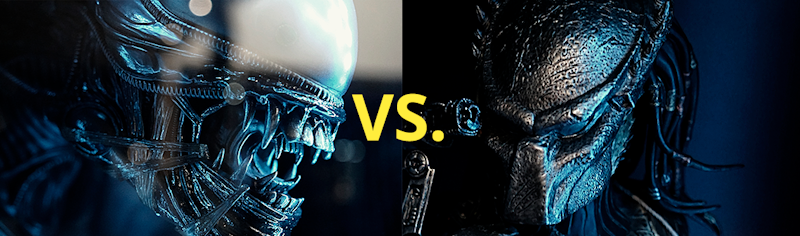

#### **Steps of making a neural network**

1. Import and split the data into a train/validation set
2. Determine the dimensions of the data
3. Initialize the network model
4. Add an input layer
5. Add the hidden layers
6. Add the output layer
7. Fit the model
8. Evaluate the model



#### **Step #1: Import and split the data into a train/validation set**

The first step is to import and pre-process the data. **Independently**, import, pre-process the data, and split it into a training and validation set.





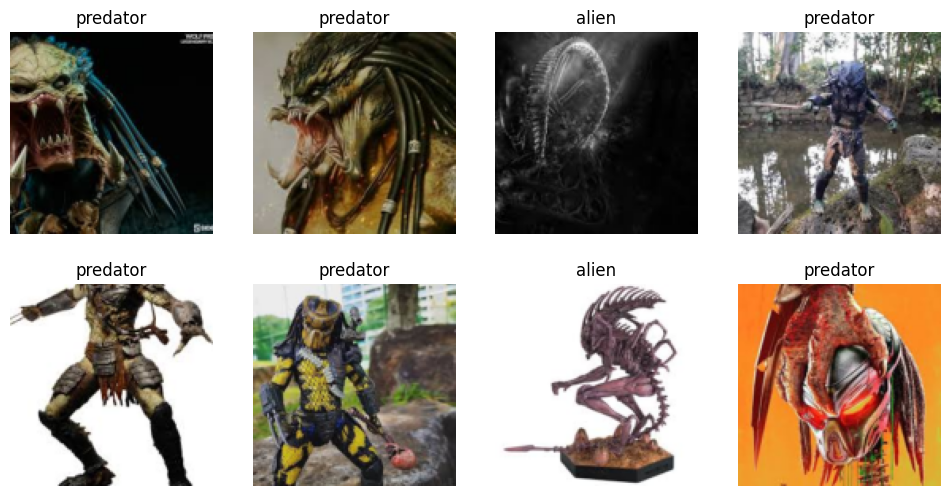

In [3]:
# Select the directory where the data is saved
data_dir = 'alien_or_predator/'

dls = ImageDataLoaders.from_folder(
    data_dir,
    train='train',
    valid='validation',
    shuffle_train=True, # shuffle train
    item_tfms=Resize(128), # item transforms
    bs=8, # batch size
    device=device, # tell to use GPU if available
    pin_memory=True # To optimize GPU memory use
)

dls.show_batch()

#### **Step #2: Determine the input shape of the data**
**This step is given to you. Run the cell below.**

In [4]:
# Get one batch of images and labels from the training set
images, labels = dls.train.one_batch()

# Get the first image from the batch
first_image = images[0]

# Print the shape of the first image
print("Image size (C x H x W):", first_image.shape)

Image size (C x H x W): torch.Size([3, 128, 128])


#### **Steps #3-6: Building the Neural Network**

**Independently**, add the following layers:
* A flattened input layer with the appropriate input dimensions
* A hidden layer with 512 neurons and ReLU activation
* A hidden layer with 256 neurons and ReLU activation
* An output layer with one neuron (for binary classification) and sigmoid activation



In [8]:
# Define the neural network architecture
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(128 * 128 * 3, 512),
    nn.ReLU(),
    nn.Linear(512, 256), 
    nn.ReLU(),
    nn.Linear(256,1),
    nn.Sigmoid()
)

summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 49152]               0
            Linear-2                  [-1, 512]      25,166,336
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                    [-1, 1]             257
           Sigmoid-7                    [-1, 1]               0
Total params: 25,297,921
Trainable params: 25,297,921
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.39
Params size (MB): 96.50
Estimated Total Size (MB): 97.08
----------------------------------------------------------------


#### **Step #7: Training the Neural Network**

**Independently**, train the model. Unfortunately, PyTorch and fast.ai do not supply an accuracy function for binary_classification, so we have provided one for you.

We will use `BCELossFlat()` for the loss function (BCE stands for binary crossentropy), and `binary_accuracy` as the evaluation metric.

For the fit, we will use 10 epochs and a learning rate of 0.0002.

In [15]:
# Define binary accuracy
def binary_accuracy(y_pred, y_true):
    y_pred = (y_pred.squeeze() > 0.5).float()
    return (y_pred == y_true).float().mean()


loss_func = BCELossFlat()

learn = Learner(
    dls,
    model,
    loss_func=loss_func,
    metrics=binary_accuracy,
    opt_func=Adam) # We are going to use the Adam optimizer

# Train the model
learn.fit(10, lr=0.0002)


epoch,train_loss,valid_loss,binary_accuracy,time
0,0.651225,0.653681,0.630000,00:48
1,0.644903,0.621606,0.640000,00:55
2,0.633525,0.628322,0.605000,01:19
3,0.621132,0.657746,0.615000,01:06
4,0.604759,0.648885,0.645000,00:48
5,0.638457,0.638490,0.610000,00:41
6,0.603041,0.619470,0.635000,00:41
7,0.570190,0.733105,0.585000,00:43
8,0.581404,0.637698,0.705000,00:43
9,0.545543,0.653548,0.665000,00:41


#### **Step #8: Evaluate the Model**


**Independently**, print the accuracy and visualize the predictions. Fill in the code below.



In [ ]:
# Calculate training accuracy
train_loss, train_accuracy = learn.validate()
print(f"Training accuracy: {train_accuracy:.4f}")

# Calculate validation accuracy
valid_loss, valid_accuracy = learn.validate(ds_idx=1)
print(f"Validation accuracy: {valid_accuracy:.4f}")

<a name="p1.2"></a>

---
### **Part 1.2: Classifying Images with Convolutional Neural Networks**
---

The steps for making a convolutional neural network are the same. The only difference is we now have two new types of  special layers in our toolkit: the **convolutional layer** and the **max pooling layer**.

#### **Steps #3-6: Building the Neural Network**

**Together**, we are going to create a CNN with four "blocks". Let's start with the first one.

We define a convolutional layer using  `nn.Conv2d(in_channels, out_channels,kernel_size,padding)`.

* `in_channels` is the input number of channels. For the input layer this will be `3` for the three color channels RGB.
* `out_channels` is the number of channels we decide to output, these are sometimes called filter or kernels as well.
* `kernel_size` is the size of the kernel. For example, `(2,2)`.
* `padding` is how much we want to pad the input.

Add a ReLU activation layer after.



In [ ]:
# Initialize the model

# Add the first convolutional layer

# Add ReLU activation


Remember that every convolutional layer will be followed by a max pooling layer. The function to add this layer is `nn.MaxPool2d(pool_size)`.

**Together**, let's add a max pooling layer with a pool size of 2x2 to the first convolutional block.



In [ ]:
# Add a max pooling layer


**Together**, let's add the second block with the following layers:

* A convolutional layer with 64 output channels, a `kernel_size=3`, and `padding=1`.
* A ReLU activation layer
* A max pool layer with 2x2 pool size

On your own, add two more blocks with the following parameters:

Block 3:
* A convolutional layer with 128 output channels, a `kernel_size=3`, and `padding=1`.
* A ReLU activation layer
* A max pool layer with 2x2 pool size


Block 4:
* A convolutional layer with 256 output channels, a `kernel_size=3`, and `padding=1`.
* A ReLU activation layer
* A max pool layer with 2x2 pool size

**Together**, we are going to flatten the output, and add a linear layer with 512 neurons and ReLU activation. What is the input size for the linear layer?

On your own, add
* one more linear layer with 256 neurons and ReLU activation
* an output layer with one neuron and Sigmoid activation

Let's take a look at the parameters in our model.

<br>

#### ***STOP!* Answer the following question: Do you think there will be more parameters to train or fewer parameters than for the fully connected network in Part 1?**

In [ ]:
summary(model.to(device), (3,128,128))

#### **Step #7: Training the Neural Network**


In [ ]:
loss_func = # FILL IN CODE HERE

learn = Learner(
    dls,
    model,
    loss_func=# FILL IN CODE HERE,
    metrics=# FILL IN CODE HERE,
    opt_func=Adam) # We are going to use the Adam optimizer

# Train the model


#### **Step #8: Evaluate the Model**
**Together**, let's print the accuracy and visualize the predictions.

In [ ]:
# Calculate training accuracy
train_loss, train_accuracy = # FILL IN CODE HERE
print(f"Training accuracy: {train_accuracy:.4f}")

# Calculate validation accuracy
valid_loss, valid_accuracy = # FILL IN CODE HERE
print(f"Validation accuracy: {valid_accuracy:.4f}")

<a name="p2"></a>

---
## **Part 2: Chihuahua or Muffin?**
---

**Chihuahua or Muffin?** This is a classic example in Computer Vision where you can easily confuse a deep learning model to misclassify a blueberry muffin with a chihuahua. In this section, we train a DNN model to differentiate between two classes of images: Chihuahua and Muffin.


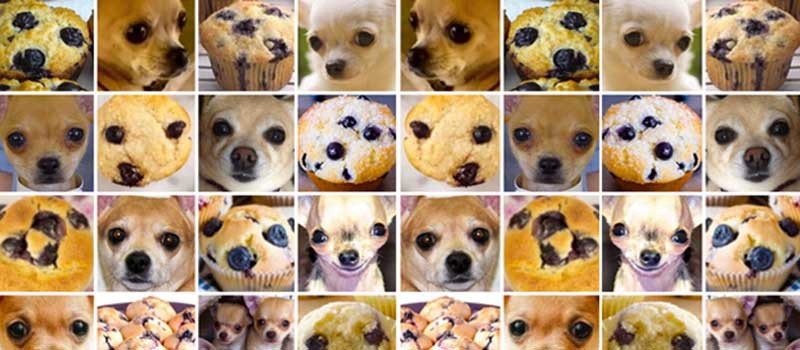

<a name="p2.1"></a>

---
### **Part 2.1: Building a Deep Neural Network for Image Classification**
---

In this section, you will follow the steps above to build, train, and evaluate a DNN model for binary image classification.

**Run the code below to download the raw data.**

In [ ]:
!gdown 1-LmbZqBxEFMp3KZc7X1YobqolXAExZc0
!unzip -qq -n chihuahua_or_muffin.zip

#### **Step #1: Import and split the data into a train/validation set**

The first step is to import and pre-process the data. This code is provided for you.

In [ ]:
# Select the directory where the data is saved
data_dir = 'chihuahua_or_muffin/'

dls = ImageDataLoaders.from_folder(data_dir,
                                   train='train',
                                   valid='validation',
                                   shuffle_train=True,
                                   item_tfms=Resize(128), # item transforms
                                   bs=64, # batch size
                                   device=device, # tell to use GPU if available
                                   pin_memory=True # To optimize GPU memory use
                                   )

dls.show_batch()

#### **Step #2: Determine the input shape of the data**

**This step is given to you. Run the cell below.**

In [ ]:
# Get one batch of images and labels from the training set
images, labels = dls.train.one_batch()

# Get the first image from the batch
first_image = images[0]

# Print the shape of the first image
print("Image size (C x H x W):", first_image.shape)

#### **Steps #3-6: Building the Neural Network**




Add the appropriate input layer, then two hidden layers: one with 1024 neurons and another with 512 neurons. Use ReLU for the hidden layers and sigmoid activation for the output layer.

In [ ]:
# Define the neural network architecture
model = nn.Sequential(
    # ADD LAYER HERE
)

Let's print a summary of the model to take a look at how many model parameters we have. **The code has been provided for you, run the cell below.** If done correctly, you should see 50,857,985 total parameters.

In [ ]:
summary(model.to(device), (3,128,128))

#### **Step #7: Training the Neural Network**



Write the code to train the model. Use `BCELossFlat()` for the loss function (BCE stands for binary crossentropy), and `binary_accuracy` as the evaluation metric.

For the fit, use 10 epochs and a learning rate of 0.0001.

**This dataset is much larger than the Alien vs. Predator dataset, so it will take longer to train.**


In [ ]:
loss_func = # FILL IN CODE HERE

learn = Learner(
    dls,
    model,
    loss_func=# FILL IN CODE HERE,
    metrics=# FILL IN CODE HERE,
    opt_func=Adam) # We are going to use the Adam optimizer

# Train the model


#### **Step #8: Evaluate the Model**


Let's print the accuracy and visualize the predictions.

---



In [ ]:
# Calculate training accuracy
train_loss, train_accuracy = # FILL IN CODE HERE
print(f"Training accuracy: {train_accuracy:.4f}")

# Calculate validation accuracy
valid_loss, valid_accuracy = # FILL IN CODE HERE
print(f"Validation accuracy: {valid_accuracy:.4f}")

<a name="p2.2"></a>

---
### **Part 2.2: Building a Convolutional Neural Network for Image Classification**
---


#### **Steps #3-6: Building the Neural Network**

Create a CNN with four blocks. The parameters to use are as follows:


Block 1:
* A convolutional layer with 64 output channels, a `kernel_size=3`, and `padding=1`.
* A ReLU activation layer
* A max pool layer with 2x2 pool size

Block 2:
* A convolutional layer with 128 output channels, a `kernel_size=3`, and `padding=1`.
* A ReLU activation layer
* A max pool layer with 2x2 pool size


Block 3:
* A convolutional layer with 256 output channels, a `kernel_size=3`, and `padding=1`.
* A ReLU activation layer
* A max pool layer with 2x2 pool size


Block 4:
* A convolutional layer with 512 output channels, a `kernel_size=3`, and `padding=1`.
* A ReLU activation layer
* A max pool layer with 2x2 pool size

Then, add the following layers:
* A flatten layer
* A linear layer with the appropriate input shape with 1024 neurons and ReLU activation
* Another linear layer with 512 neurons and ReLU activation
* An output layer with one neuron and sigmoid activation.



In [ ]:
# Initialize the model and add layers


Let's take a look at the parameters in our model. If done correctly, you should see 35,631,745 total parameters.

In [ ]:
summary(model.to(device), (3,128,128))

#### **Step #7: Training the Neural Network**


Use the same parameters as Part 3.1.

In [ ]:
loss_func =

learn = Learner(
    dls,
    model,
    loss_func=# FILL IN CODE HERE,
    metrics=# FILL IN CODE HERE,
    opt_func=Adam) # We are going to use the Adam optimizer

# Train the model


#### **Step #8: Evaluate the Model**


Let's print the accuracy and visualize the predictions.





In [ ]:
# Calculate training accuracy
train_loss, train_accuracy = # FILL IN CODE HERE
print(f"Training accuracy: {train_accuracy:.4f}")

# Calculate validation accuracy
valid_loss, valid_accuracy = # FILL IN CODE HERE
print(f"Validation accuracy: {valid_accuracy:.4f}")

<a name="p3"></a>

---
## **Part 3: Data Augmentation**
---

In this section, we will revisit the Alien vs. Predator dataset. It is a challenging dataset because it is smaller than we would prefer for training deep neural networks. However, we will see how to properly increase the size of or "augment" small image datasets to overcome this.

#### **Step #1: Import and split the data into a train/validation set**

**Together**, we will import, pre-process the data, and split it into a training and validation set. We will use the validation set to help us improve the model in the next section.

This time, we'll add data augmentation by adding some item and batch transforms when we build our ImageDataLoader.



#### **Problem #3.1**

**Together**, use the following parameters when building the ImageDataLoader:

* Resize all images to 128x128
* Apply default data augmentation using `aug_transforms()`

In [ ]:
# Select the directory where the data is saved
data_dir = 'alien_or_predator/'

dls = ImageDataLoaders.from_folder(
    data_dir,
    train='train',
    valid='validation',
    shuffle_train=True, # shuffle train
    item_tfms=#FILL IN CODE HERE, # item transforms
    batch_tfms=#FILL IN CODE HERE, # add data augmentation
    bs=8, # batch size
    device=device, # tell to use GPU if available
    pin_memory=True # To optimize GPU memory use
)

dls.show_batch(nrows=2, ncols=4)

#### **Problem #3.2**

**Together**, let's customize the data augmentation transforms with the following parameters:

* `do_flip=True`
* `flip_vert=False`
* `max_rotate=30.0`

In [ ]:
batch_tfms=aug_transforms(# FILL IN CODE HERE

dls = ImageDataLoaders.from_folder(
    data_dir,
    train='train',
    valid='validation',
    shuffle_train=True, # shuffle train
    item_tfms=Resize(128), # item transforms
    batch_tfms=#FILL IN CODE HERE, # add data augmentation
    bs=8, # batch size
    device=device, # tell to use GPU if available
    pin_memory=True # To optimize GPU memory use
)

dls.show_batch(nrows=2, ncols=4)

---
#### **Try Steps #2 - #8 on your own!**
---

#### **Step #2: Determine the input shape of the data**
**This step is given to you. Run the cell below.**

In [ ]:
# Get one batch of images and labels from the training set
images, labels = dls.train.one_batch()

# Get the first image from the batch
first_image = images[0]

# Print the shape of the first image
print("Image size (C x H x W):", first_image.shape)

#### **Steps #3-6: Building the Neural Network**




**Independently**, build a CNN with the following parameters:

Block 1:
* A convolutional layer with 32 output channels, a `kernel_size=3`, and `padding=1`.
* A ReLU activation layer
* A max pool layer with 2x2 pool size


Block 2:
* A convolutional layer with 64 output channels, a `kernel_size=3`, and `padding=1`.
* A ReLU activation layer
* A max pool layer with 2x2 pool size

Block 3:
* A convolutional layer with 128 output channels, a `kernel_size=3`, and `padding=1`.
* A ReLU activation layer
* A max pool layer with 2x2 pool size


Block 4:
* A convolutional layer with 256 output channels, a `kernel_size=3`, and `padding=1`.
* A ReLU activation layer
* A max pool layer with 2x2 pool size

Finally, add:
* A flatten layer
* A linear layer with 512 neurons and ReLU activation
* Another linear layer with 256 neurons and ReLU activation
* An output layer with one neuron and Sigmoid activation

In [ ]:
# Define the neural network architecture
model = # WRITE YOUR CODE HERE

#### **Step #7: Training the Neural Network**
**Independently**, train the neural network. Use `BCELossFlat()` for the loss function (BCE stands for binary crossentropy), and `binary_accuracy` as the evaluation metric.

For the fit, we will use 10 epochs and a learning rate of 0.0002.

In [ ]:
loss_func = # FILL IN CODE HERE

learn = Learner(
    dls,
    model,
    loss_func=# FILL IN CODE HERE,
    metrics=# FILL IN CODE HERE,
    opt_func=Adam) # We are going to use the Adam optimizer

# Train the model
# FILL IN CODE HERE

learn.recorder.plot_loss()

#### **Step #8: Evaluate the Model**
**Independently**, print the accuracy and visualize the predictions.

In [ ]:
# Calculate training accuracy
train_loss, train_accuracy = # FILL IN CODE HERE
print(f"Training accuracy: {train_accuracy:.4f}")

# Calculate validation accuracy
valid_loss, valid_accuracy = # FILL IN CODE HERE
print(f"Validation accuracy: {valid_accuracy:.4f}")

---

<center>

#### **Back to lecture**

---

<a name="p4"></a>

---
## **Part 4: [ADDITIONAL PRACTICE] Classification of Dogs and Cats**
---

In this section, you can choose what model and tools you want to use to achieve 85% accuracy on the Dogs and Cats dataset. This is a large dataset (it will not have the small-dataset problems of the Alien vs. Predator dataset). It will also take much longer to train, so keep that in mind when choosing hyperparameters like the number of epochs.

#### **Step #1: Import and split the data into a train/validation set**


In [ ]:
path = untar_data(URLs.DOGS)
dls = ImageDataLoaders.from_folder(path,
                                   train='train',
                                   valid='valid',
                                   item_tfms = [Resize(128)],
                                   bs=64)
dls.show_batch(max_n=16, figsize=(9,9))

#### **Step #2: Determine the input shape of the data**

**This step is given to you. Run the cell below.**

In [ ]:
# Get one batch of images and labels from the training set
images, labels = dls.train.one_batch()

# Get the first image from the batch
first_image = images[0]

# Print the shape of the first image
print("Image size (C x H x W):", first_image.shape)

#### **Steps #3-6: Building the Neural Network**





In [ ]:
model = # BUILD YOUR MODEL HERE


#### **Step #7: Training the Neural Network**



In [ ]:
loss_func = # FILL IN CODE HERE

learn = Learner(
    dls,
    model,
    loss_func=# FILL IN CODE HERE,
    metrics=# FILL IN CODE HERE,
    opt_func=Adam) # We are going to use the Adam optimizer

# Train the model


#### **Step #8: Evaluate the Model**
Let's print the accuracy and visualize the predictions.


In [ ]:
# Calculate training accuracy
train_loss, train_accuracy = # FILL IN CODE HERE
print(f"Training accuracy: {train_accuracy:.4f}")

# Calculate validation accuracy
valid_loss, valid_accuracy = # FILL IN CODE HERE
print(f"Validation accuracy: {valid_accuracy:.4f}")

# End of notebook
---
© 2023 The Coding School, All rights reserved